Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import VAR

import yfinance as yf

## Downloading 2023 data for other companies for performing cross-sectional analysis

In [2]:
google = yf.Ticker("GOOG")
apple = yf.Ticker("AAPL")
microsoft = yf.Ticker("MSFT")
nvidia = yf.Ticker("NVDA")
amazon = yf.Ticker("AMZN")
meta = yf.Ticker("META")

google_data = google.history(start='2023-01-01', end='2024-01-01')
apple_data = apple.history(start='2023-01-01', end='2024-01-01')
microsoft_data = microsoft.history(start='2023-01-01', end='2024-01-01')
nvidia_data = nvidia.history(start='2023-01-01', end='2024-01-01')
amazon_data = amazon.history(start='2023-01-01', end='2024-01-01')
meta_data = meta.history(start='2023-01-01', end='2024-01-01')

In [3]:
close_df = pd.DataFrame()
close_df["Apple"] = apple_data.Close
# close_df["Google"] = google_data.Close
close_df["Microsoft"] = microsoft_data.Close
# close_df["Nvidia"] = nvidia_data.Close
# close_df["Amazon"] = amazon_data.Close
# close_df["Meta"] = meta_data.Close
# close_df["Apple_Volume"] = apple_data.Volume
close_df

,Apple,Microsoft
Date,,
2023-01-03 00:00:00-05:00,124.048042,236.609207
2023-01-04 00:00:00-05:00,125.327507,226.259171
2023-01-05 00:00:00-05:00,123.998466,219.553360
2023-01-06 00:00:00-05:00,128.560867,222.140869
2023-01-09 00:00:00-05:00,129.086533,224.303711
...,...,...
2023-12-22 00:00:00-05:00,193.091385,373.215424
2023-12-26 00:00:00-05:00,192.542816,373.295135
2023-12-27 00:00:00-05:00,192.642548,372.707275


<Axes: xlabel='Date'>

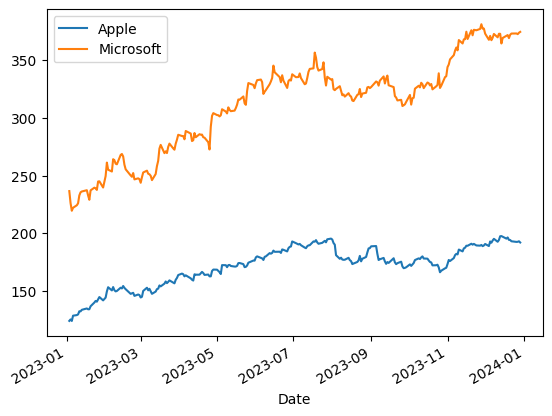

In [4]:
close_df.plot()

In [5]:
close_df.corr()

,Apple,Microsoft
Apple,1.000000,0.948934
Microsoft,0.948934,1.000000


### Adding the missing columns

In [6]:
dataset = pd.read_csv("../apple_2023_masked.csv")

In [7]:
daynumber = "1day"
close_df[daynumber] = list(dataset[daynumber])

daynumber = "2day"
close_df[daynumber] = list(dataset[daynumber])

daynumber = "3day"
close_df[daynumber] = list(dataset[daynumber])

daynumber = "4day"
close_df[daynumber] = list(dataset[daynumber])

daynumber = "5day"
close_df[daynumber] = list(dataset[daynumber])
close_df

,Apple,Microsoft,1day,2day,3day,4day,5day
Date,,,,,,,
2023-01-03 00:00:00-05:00,124.048042,236.609207,124.048042,124.048042,124.048042,124.048042,124.048042
2023-01-04 00:00:00-05:00,125.327507,226.259171,125.327515,125.327515,125.327515,125.327515,125.327515
2023-01-05 00:00:00-05:00,123.998466,219.553360,123.998451,123.998451,123.998451,123.998451,123.998451
2023-01-06 00:00:00-05:00,128.560867,222.140869,128.560867,128.560867,128.560867,128.560867,128.560867
2023-01-09 00:00:00-05:00,129.086533,224.303711,129.086517,129.086517,129.086517,129.086517,129.086517
...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,193.091385,373.215424,193.091385,193.091385,193.091385,193.091385,193.091385
2023-12-26 00:00:00-05:00,192.542816,373.295135,192.542816,192.542816,192.542816,192.542816,192.542816
2023-12-27 00:00:00-05:00,192.642548,372.707275,192.642548,192.642548,192.642548,192.642548,192.642548


## Define an imputation method that we will use repeateadly

In [8]:
# define a function for imputing missing values
def impute_missing_values(data, results):
    for i in range(len(data)):
        if np.isnan(data[daynumber].iloc[i]):  # Check if the stock price is np.nan
            # Get the previous available data points up to the maxlags
            data_slice = data.iloc[i - results.k_ar:i].values
            if len(data_slice) == results.k_ar:
                forecast = results.forecast(data_slice, steps=1)
                data[daynumber].iloc[i] = forecast[0, 0]  # Impute the missing value using the forecast
    return data

## Performing Vector Auto Regression for `1day` column of missing values

In [9]:
daynumber = '1day'

close_df_filled = close_df.copy()
close_df_filled["VAR_Imputation"] = close_df_filled[daynumber].interpolate()
close_df_filled.drop(columns = ['Apple', '1day', '2day', '3day', '4day', '5day'], inplace = True)
close_df_filled

,Microsoft,VAR_Imputation
Date,,
2023-01-03 00:00:00-05:00,236.609207,124.048042
2023-01-04 00:00:00-05:00,226.259171,125.327515
2023-01-05 00:00:00-05:00,219.553360,123.998451
2023-01-06 00:00:00-05:00,222.140869,128.560867
2023-01-09 00:00:00-05:00,224.303711,129.086517
...,...,...
2023-12-22 00:00:00-05:00,373.215424,193.091385
2023-12-26 00:00:00-05:00,373.295135,192.542816
2023-12-27 00:00:00-05:00,372.707275,192.642548


In [10]:
# Fit the VAR model
model1 = VAR(close_df_filled)
results1 = model1.fit(maxlags=10, ic='aic')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


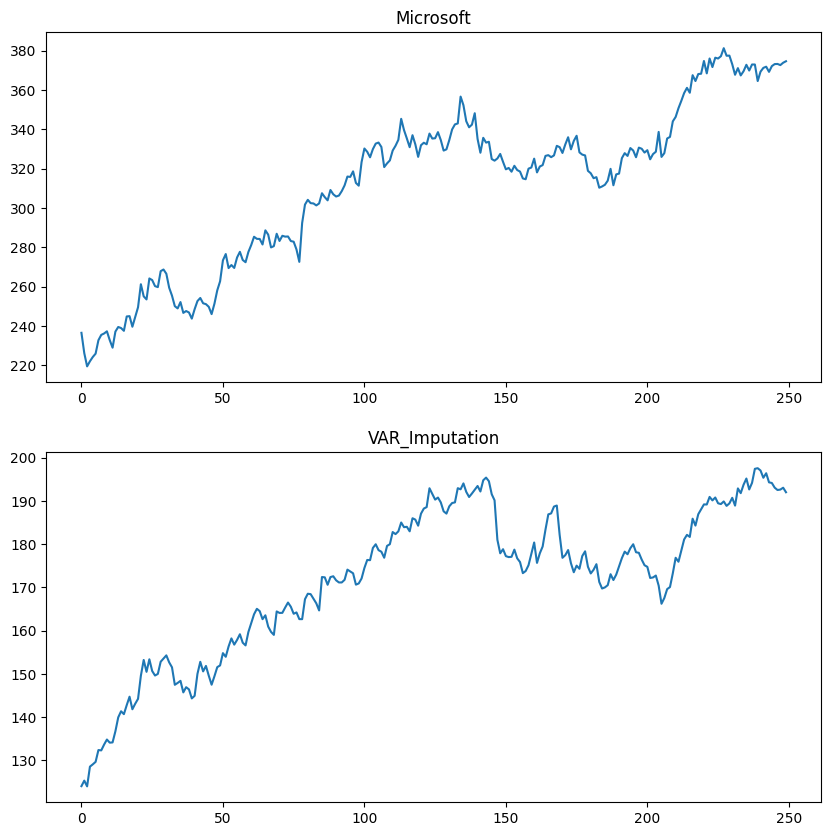

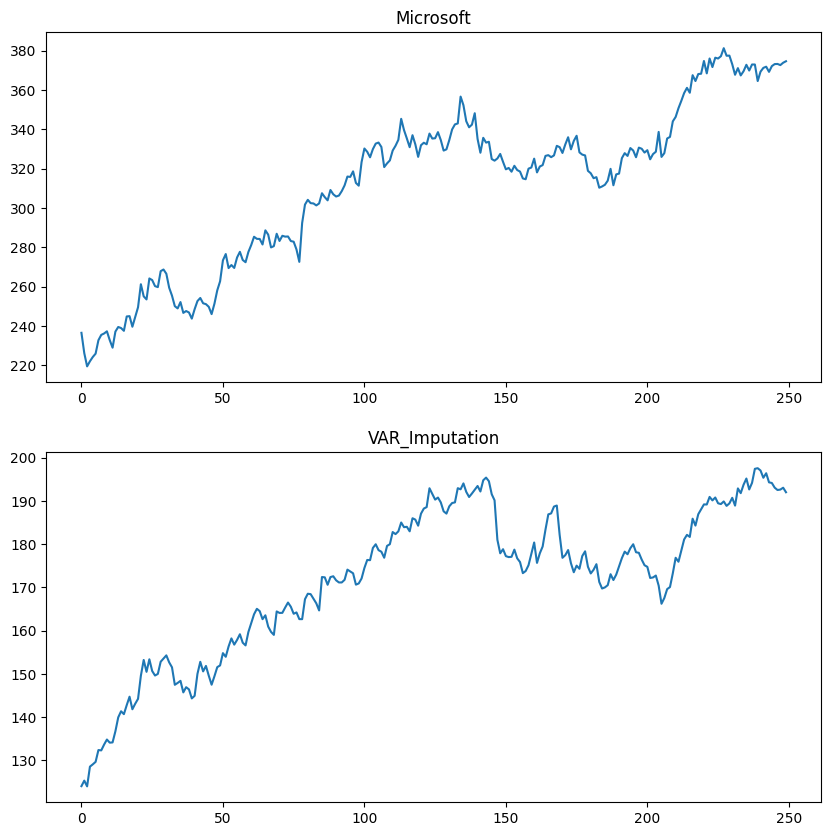

In [11]:
results1.plot()

In [12]:
results1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, Jun, 2024
Time:                     21:01:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.33238
Nobs:                     248.000    HQIC:                   4.24774
Log likelihood:          -1213.44    FPE:                    66.0703
AIC:                      4.19071    Det(Omega_mle):         63.4847
--------------------------------------------------------------------
Results for equation Microsoft
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     6.109661         3.496996            1.747           0.081
L1.Microsoft              1.005267         0.075111           13.384           0.000
L1.VAR_Imputation        -0.264597      

In [13]:
# Impute the missing values
cr = set()
cr.add(daynumber)
list((set({'Apple', '1day', '2day', '3day', '4day', '5day'})).difference(cr))

imputed_data1 = impute_missing_values(close_df.drop(columns=['Apple', '2day', '3day', '4day', '5day']).copy(), results1)
imputed_data1

,Microsoft,1day
Date,,
2023-01-03 00:00:00-05:00,236.609207,124.048042
2023-01-04 00:00:00-05:00,226.259171,125.327515
2023-01-05 00:00:00-05:00,219.553360,123.998451
2023-01-06 00:00:00-05:00,222.140869,128.560867
2023-01-09 00:00:00-05:00,224.303711,129.086517
...,...,...
2023-12-22 00:00:00-05:00,373.215424,193.091385
2023-12-26 00:00:00-05:00,373.295135,192.542816
2023-12-27 00:00:00-05:00,372.707275,192.642548


## Performing Vector Auto Regression for `2day` column of missing values

In [14]:
daynumber = '2day'

del close_df_filled
close_df_filled = close_df.copy()
close_df_filled["VAR_Imputation"] = close_df_filled[daynumber].interpolate()
close_df_filled.drop(columns = ['Apple', '1day', '2day', '3day', '4day', '5day'], inplace = True)
close_df_filled

,Microsoft,VAR_Imputation
Date,,
2023-01-03 00:00:00-05:00,236.609207,124.048042
2023-01-04 00:00:00-05:00,226.259171,125.327515
2023-01-05 00:00:00-05:00,219.553360,123.998451
2023-01-06 00:00:00-05:00,222.140869,128.560867
2023-01-09 00:00:00-05:00,224.303711,129.086517
...,...,...
2023-12-22 00:00:00-05:00,373.215424,193.091385
2023-12-26 00:00:00-05:00,373.295135,192.542816
2023-12-27 00:00:00-05:00,372.707275,192.642548


In [15]:
# Fit the VAR model
model2 = VAR(close_df_filled)
results2 = model2.fit(maxlags=10, ic='aic')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [16]:
# Impute the missing values
cr = set()
cr.add(daynumber)
colList = list((set({'Apple', '1day', '2day', '3day', '4day', '5day'})).difference(cr))

imputed_data2 = impute_missing_values(close_df.drop(columns=colList).copy(), results2)
imputed_data2

,Microsoft,2day
Date,,
2023-01-03 00:00:00-05:00,236.609207,124.048042
2023-01-04 00:00:00-05:00,226.259171,125.327515
2023-01-05 00:00:00-05:00,219.553360,123.998451
2023-01-06 00:00:00-05:00,222.140869,128.560867
2023-01-09 00:00:00-05:00,224.303711,129.086517
...,...,...
2023-12-22 00:00:00-05:00,373.215424,193.091385
2023-12-26 00:00:00-05:00,373.295135,192.542816
2023-12-27 00:00:00-05:00,372.707275,192.642548


## Performing Vector Auto Regression for `3day` column of missing values

In [17]:
daynumber = '3day'

del close_df_filled
close_df_filled = close_df.copy()
close_df_filled["VAR_Imputation"] = close_df_filled[daynumber].interpolate()
close_df_filled.drop(columns = ['Apple', '1day', '2day', '3day', '4day', '5day'], inplace = True)
close_df_filled

,Microsoft,VAR_Imputation
Date,,
2023-01-03 00:00:00-05:00,236.609207,124.048042
2023-01-04 00:00:00-05:00,226.259171,125.327515
2023-01-05 00:00:00-05:00,219.553360,123.998451
2023-01-06 00:00:00-05:00,222.140869,128.560867
2023-01-09 00:00:00-05:00,224.303711,129.086517
...,...,...
2023-12-22 00:00:00-05:00,373.215424,193.091385
2023-12-26 00:00:00-05:00,373.295135,192.542816
2023-12-27 00:00:00-05:00,372.707275,192.642548


In [18]:
# Fit the VAR model
model3 = VAR(close_df_filled)
results3 = model3.fit(maxlags=10, ic='aic')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
# Impute the missing values
cr = set()
cr.add(daynumber)
colList = list((set({'Apple', '1day', '2day', '3day', '4day', '5day'})).difference(cr))

imputed_data3 = impute_missing_values(close_df.drop(columns=colList).copy(), results3)
imputed_data3

,Microsoft,3day
Date,,
2023-01-03 00:00:00-05:00,236.609207,124.048042
2023-01-04 00:00:00-05:00,226.259171,125.327515
2023-01-05 00:00:00-05:00,219.553360,123.998451
2023-01-06 00:00:00-05:00,222.140869,128.560867
2023-01-09 00:00:00-05:00,224.303711,129.086517
...,...,...
2023-12-22 00:00:00-05:00,373.215424,193.091385
2023-12-26 00:00:00-05:00,373.295135,192.542816
2023-12-27 00:00:00-05:00,372.707275,192.642548


## Performing Vector Auto Regression for `4day` column of missing values

In [20]:
daynumber = '4day'

del close_df_filled
close_df_filled = close_df.copy()
close_df_filled["VAR_Imputation"] = close_df_filled[daynumber].interpolate()
close_df_filled.drop(columns = ['Apple', '1day', '2day', '3day', '4day', '5day'], inplace = True)
close_df_filled

,Microsoft,VAR_Imputation
Date,,
2023-01-03 00:00:00-05:00,236.609207,124.048042
2023-01-04 00:00:00-05:00,226.259171,125.327515
2023-01-05 00:00:00-05:00,219.553360,123.998451
2023-01-06 00:00:00-05:00,222.140869,128.560867
2023-01-09 00:00:00-05:00,224.303711,129.086517
...,...,...
2023-12-22 00:00:00-05:00,373.215424,193.091385
2023-12-26 00:00:00-05:00,373.295135,192.542816
2023-12-27 00:00:00-05:00,372.707275,192.642548


In [21]:
# Fit the VAR model
model4 = VAR(close_df_filled)
results4 = model4.fit(maxlags=10, ic='aic')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
# Impute the missing values
cr = set()
cr.add(daynumber)
colList = list((set({'Apple', '1day', '2day', '3day', '4day', '5day'})).difference(cr))

imputed_data4 = impute_missing_values(close_df.drop(columns=colList).copy(), results4)
imputed_data4

,Microsoft,4day
Date,,
2023-01-03 00:00:00-05:00,236.609207,124.048042
2023-01-04 00:00:00-05:00,226.259171,125.327515
2023-01-05 00:00:00-05:00,219.553360,123.998451
2023-01-06 00:00:00-05:00,222.140869,128.560867
2023-01-09 00:00:00-05:00,224.303711,129.086517
...,...,...
2023-12-22 00:00:00-05:00,373.215424,193.091385
2023-12-26 00:00:00-05:00,373.295135,192.542816
2023-12-27 00:00:00-05:00,372.707275,192.642548


## Performing Vector Auto Regression for `5day` column of missing values

In [23]:
daynumber = '5day'

del close_df_filled
close_df_filled = close_df.copy()
close_df_filled["VAR_Imputation"] = close_df_filled[daynumber].interpolate()
close_df_filled.drop(columns = ['Apple', '1day', '2day', '3day', '4day', '5day'], inplace = True)
close_df_filled

,Microsoft,VAR_Imputation
Date,,
2023-01-03 00:00:00-05:00,236.609207,124.048042
2023-01-04 00:00:00-05:00,226.259171,125.327515
2023-01-05 00:00:00-05:00,219.553360,123.998451
2023-01-06 00:00:00-05:00,222.140869,128.560867
2023-01-09 00:00:00-05:00,224.303711,129.086517
...,...,...
2023-12-22 00:00:00-05:00,373.215424,193.091385
2023-12-26 00:00:00-05:00,373.295135,192.542816
2023-12-27 00:00:00-05:00,372.707275,192.642548


In [24]:
# Fit the VAR model
model5 = VAR(close_df_filled)
results5 = model5.fit(maxlags=10, ic='aic')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
# Impute the missing values
cr = set()
cr.add(daynumber)
colList = list((set({'Apple', '1day', '2day', '3day', '4day', '5day'})).difference(cr))

imputed_data5 = impute_missing_values(close_df.drop(columns=colList).copy(), results5)
imputed_data5

,Microsoft,5day
Date,,
2023-01-03 00:00:00-05:00,236.609207,124.048042
2023-01-04 00:00:00-05:00,226.259171,125.327515
2023-01-05 00:00:00-05:00,219.553360,123.998451
2023-01-06 00:00:00-05:00,222.140869,128.560867
2023-01-09 00:00:00-05:00,224.303711,129.086517
...,...,...
2023-12-22 00:00:00-05:00,373.215424,193.091385
2023-12-26 00:00:00-05:00,373.295135,192.542816
2023-12-27 00:00:00-05:00,372.707275,192.642548


## Collect all the imputed data together

In [26]:
close_df_imputed  = close_df.copy()
close_df_imputed['1day'] = imputed_data1['1day']
close_df_imputed['2day'] = imputed_data2['2day']
close_df_imputed['3day'] = imputed_data3['3day']
close_df_imputed['4day'] = imputed_data4['4day']
close_df_imputed['5day'] = imputed_data5['5day']
close_df_imputed

,Apple,Microsoft,1day,2day,3day,4day,5day
Date,,,,,,,
2023-01-03 00:00:00-05:00,124.048042,236.609207,124.048042,124.048042,124.048042,124.048042,124.048042
2023-01-04 00:00:00-05:00,125.327507,226.259171,125.327515,125.327515,125.327515,125.327515,125.327515
2023-01-05 00:00:00-05:00,123.998466,219.553360,123.998451,123.998451,123.998451,123.998451,123.998451
2023-01-06 00:00:00-05:00,128.560867,222.140869,128.560867,128.560867,128.560867,128.560867,128.560867
2023-01-09 00:00:00-05:00,129.086533,224.303711,129.086517,129.086517,129.086517,129.086517,129.086517
...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,193.091385,373.215424,193.091385,193.091385,193.091385,193.091385,193.091385
2023-12-26 00:00:00-05:00,192.542816,373.295135,192.542816,192.542816,192.542816,192.542816,192.542816
2023-12-27 00:00:00-05:00,192.642548,372.707275,192.642548,192.642548,192.642548,192.642548,192.642548


In [33]:
close_df_imputed[close_df_imputed['1day'].isna()]

,Apple,Google,Microsoft,Nvidia,Amazon,Meta,1day,2day,3day,4day,5day
Date,,,,,,,,,,,


<Axes: xlabel='Date'>

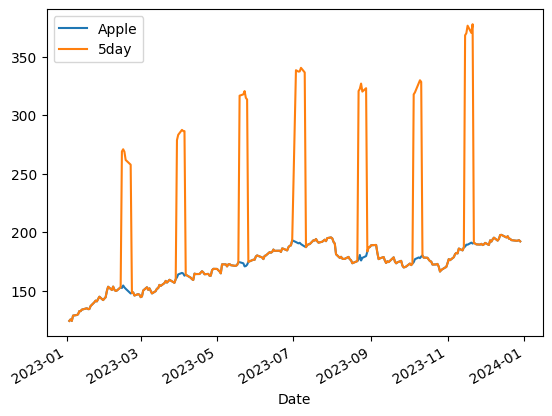

In [27]:
close_df_imputed[["Apple", "5day"]].plot()

In [39]:
list(close_df_imputed['5day'])

[124.04804229736328,
 125.3275146484375,
 123.99845123291016,
 128.5608673095703,
 129.08651733398438,
 129.66180419921875,
 132.39926147460938,
 132.31991577148438,
 133.6588897705078,
 134.8292236328125,
 134.10519409179688,
 134.16470336914062,
 136.7434539794922,
 139.9569854736328,
 141.36538696289062,
 140.7008514404297,
 142.78372192382812,
 144.7375946044922,
 141.83154296875,
 143.11097717285156,
 144.24168395996094,
 149.587646484375,
 153.237548828125,
 150.49021911621094,
 153.38633728027344,
 150.67864990234375,
 149.63722229003906,
 150.0047607421875,
 152.8258819580078,
 95.64196042085642,
 96.23602646221289,
 98.22510613991369,
 96.85830861402864,
 95.69777644835146,
 147.91876220703125,
 148.4054718017578,
 145.7333984375,
 146.93533325195312,
 146.42874145507812,
 144.34271240234375,
 144.938720703125,
 150.02464294433594,
 152.80599975585938,
 150.5908660888672,
 151.85240173339844,
 149.5875701904297,
 147.511474609375,
 149.4683837890625,
 151.57424926757812,
 151.